# AMAL - TP 4 - Réseaux récurrents

<span style="color:red">Bonjour, comme indiqué ce matin, le code ne fonctionne pas. Je l'uploade afin que vous puissez faire un retour et que je comprenne les erreurs. Je le complèterai ensuite. En particulier, comme je n'arrive pas à faire diminuer l'erreur d'apprentissage, je n'ai pas encore séparé le dataset en train / validation / test. Merci !</span>

In [1]:
import numpy as np
import torch
from datamaestro import prepare_dataset 
from torch.utils.tensorboard import SummaryWriter
import time
import csv
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
torch.autograd.set_detect_anomaly(True)

## Exercice 1

In [9]:
class RNN(torch.nn.Module):
    def __init__(self, dim, latent, batch):
        super(RNN, self).__init__()
        
        self.Wi = torch.nn.Linear(dim, latent, bias=False)
        self.Wh = torch.nn.Linear(latent, latent)
        self.latent = latent
        self.h = torch.zeros(batch, latent, requires_grad=True)
        
    def one_step(self, x, h):
        return torch.nn.Tanh()(self.Wi(x) + self.Wh(h)) 
    
    def forward(self, x):
        length, batch = x.shape[0], x.shape[1] 
        hs = []
        hs.append(self.one_step(x[0], self.h))
        for i in range(1, length):
            hs.append(self.one_step(x[i], hs[-1]))
        return hs[-1]    # pour cet exercice, hs[-1] suffit. Je généraliserai pour les exercices suivants.
       # return torch.cat(hs, dim=0)

Je fais juste le test avec 2 villes pour l'instant

In [4]:
n_cities = 2
dim = 1
batch = 16
latent = 20
length = 100

In [5]:
temp_data = pd.read_csv('tempAMAL_train.csv')
temp_data = temp_data.iloc[:,1: 1+n_cities]
data = np.asarray(temp_data)
cols = temp_data.columns

n_times = data.shape[0]
data[np.isnan(data)] = np.mean(data[~np.isnan(data)])
data = (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
increment = np.repeat(np.arange(0, length), batch).reshape((length, batch))

In [10]:
model = torch.nn.Sequential(
        RNN(dim, latent, batch),
        torch.nn.Linear(latent, n_cities)
   #     torch.nn.Sigmoid() 
)

In [11]:
def test_model(n_test):
    p_true = 0

    for i in range(n_test):
        with torch.no_grad():
            random_cities = np.random.randint(0, n_cities, size=(batch))
            random_times = np.random.randint(0, n_times-length-dim, size=(batch))
            x_numpy = np.zeros((length, batch, dim))
            for k in range(dim):
                x_numpy[:, :, k] = data[np.repeat(np.reshape(random_times+k, (1, batch)), length, axis=0)+increment, random_cities]
            x = torch.from_numpy(x_numpy).float()
            predicted_cities = model(x).detach().numpy()
            ok = np.sum(np.argmax(predicted_cities, axis=1) == random_cities) / batch
            p_true += ok

    print(p_true / n_test)
    
test_model(100)

0.49875


In [12]:
#optim = torch.optim.SGD(params=model.parameters(),lr=EPS)
optim = torch.optim.Adam(params=[x for x in model.parameters()] + [model[0].h], lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
loss = torch.nn.CrossEntropyLoss()

In [13]:
n_train = 100
batch * length * dim * n_train / (data.shape[0]*data.shape[1])

7.197480881691408

In [14]:
writer = SummaryWriter()
losses = []
for i in range(n_train):
    # each time: we see batch * length data
    optim.zero_grad()
    random_cities = np.random.randint(0, n_cities, size=(batch))
    random_times = np.random.randint(0, n_times-length-dim, size=(batch))
    x_numpy = np.zeros((length, batch, dim))
    for k in range(dim):
        x_numpy[:, :, k] = data[np.repeat(np.reshape(random_times+k, (1, batch)), length, axis=0)+increment, random_cities]
    x = torch.from_numpy(x_numpy).float()
    l = loss(model(x), torch.from_numpy(random_cities))
    l.backward()
    optim.step()
    writer.add_scalar('Loss/train', l, i)
    losses.append(l)

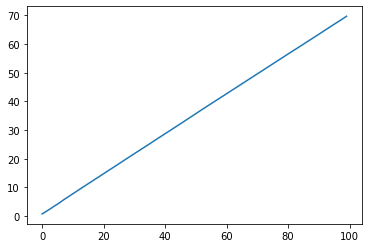

In [15]:
plt.plot(np.cumsum(losses))

In [18]:
print(model[0].Wi.weight.grad)
print(model[0].Wi.weight)

tensor([[-0.0022],
        [-0.0093],
        [-0.0184],
        [ 0.0336],
        [ 0.0009],
        [-0.0120],
        [-0.0073],
        [ 0.0204],
        [-0.0212],
        [ 0.0010],
        [-0.0165],
        [-0.0010],
        [-0.0012],
        [ 0.0028],
        [ 0.0030],
        [-0.0270],
        [-0.0157],
        [ 0.0063],
        [ 0.0013],
        [-0.0121]])
Parameter containing:
tensor([[-0.6528],
        [ 0.0549],
        [-0.8539],
        [-0.4859],
        [ 0.8753],
        [-0.7983],
        [-0.7484],
        [-0.1982],
        [ 0.5107],
        [ 0.8995],
        [ 0.9396],
        [ 0.1030],
        [-0.6228],
        [-0.4308],
        [-0.0502],
        [-0.7215],
        [ 0.1179],
        [-0.2919],
        [-0.7547],
        [ 0.1588]], requires_grad=True)


In [19]:
test_model(100)

0.515625


## Exercice 2

J'ai codé des choses mais ce n'est pas la peine de les reviewer tant que l'exercice 1 ne fonctionne pas.